### from own EIs

In [ ]:
import h5py
import numpy as np
from extract_data_snippets import extract_snippets
from verify_cluster import compute_ei
from run_template_scoring_gpu import run_template_scoring_gpu
from suppress_close_peaks import suppress_close_peaks
from scipy.signal import argrelextrema

# --- Parameters ---
sampling_rate = 20000
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'
h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'
h5_ei_path = '/Volumes/Lab/Users/alexth/axolotl/ks_eis_subset.h5'

unit_id_to_process = 8  # change this to desired KS unit

# --- Load spike times and KS template ---
with h5py.File(h5_in_path, 'r') as f:
    spikes_sec = np.array(f[f'/spikes/unit_{unit_id_to_process}'][:]).flatten()
    spike_times = np.round(spikes_sec * sampling_rate).astype(np.int32)

# --- Compute EI template ---
spike_subset = spike_times[:1000]  # or fewer if needed
snips = extract_snippets(dat_path, spike_subset, window=(-20, 60))
ei_template = compute_ei(snips)

# --- Channel selection and normalization ---
ei_peak2peak = ei_template.max(axis=1) - ei_template.min(axis=1)
selected_by_ei = np.where(ei_peak2peak > 15)[0]
if len(selected_by_ei) > 80:
    selected_by_ei = np.argsort(ei_peak2peak)[-80:]
elif len(selected_by_ei) < 30:
    selected_by_ei = np.argsort(ei_peak2peak)[-30:]

ei_masks = np.zeros_like(ei_template)
ei_masks[selected_by_ei, :] = 1
ei_norms = np.linalg.norm(ei_template * ei_masks, axis=1)

ei_masks_subset = ei_masks[selected_by_ei, :]
ei_norms_subset = ei_norms[selected_by_ei]

print("now running template scan")
# --- Template scoring ---
mean_score, max_score, valid_score = run_template_scoring_gpu(
    dat_path=dat_path,
    ei_template=ei_template[selected_by_ei, :],
    ei_masks=ei_masks_subset,
    ei_norms=ei_norms_subset,
    selected_channels=selected_by_ei,
    start_sample=0,
    total_samples=36_000_000,  # or however long the recording is
    dtype='int16'
)

# --- Detect spike times from template scoring ---
score_threshold = max(np.mean(np.sum((ei_template[selected_by_ei, :] * ei_masks[selected_by_ei, :]) ** 2, axis=1)) / 2, 20000)

is_peak = argrelextrema(mean_score, np.greater_equal, order=1)[0]
#valid_inds = is_peak[(mean_score[is_peak] > score_threshold) & (valid_score[is_peak] > 3)]
peak_mask = (mean_score[is_peak] > score_threshold) & (valid_score[is_peak] > 3)
candidates = is_peak[peak_mask]
refractory_samples = int(0.001 * 20000)
valid_inds = suppress_close_peaks(candidates, mean_score, refractory_samples)

final_spike_times = valid_inds + 19  # offset from template alignment

print("Final spikes: ", len(final_spike_times))



### from data000 EIs

In [74]:
from run_multi_gpu_ei_scan import run_multi_gpu_ei_scan


#mean_score, max_score, valid_score, selected_channels, ei_template = run_multi_gpu_ei_scan(
#    ei_mat_path='/Volumes/Lab/Users/alexth/axolotl/ei_template_data000_cell388.mat',
#    dat_path='/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat',
#    total_samples=36_000_000,   # fill in with length of your recording in samples
#    save_prefix = '/Volumes/Lab/Users/alexth/axolotl/201703151_data000_tmp'
#)

mean_score, max_score, valid_score, selected_channels, ei_template = run_multi_gpu_ei_scan(
    ei_mat_path='/Volumes/Lab/Users/alexth/axolotl/ei_template_data001_cell231.mat',
    dat_path='/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat',
    total_samples=36_000_000,   # fill in with length of your recording in samples
    save_prefix = '/Volumes/Lab/Users/alexth/axolotl/201703151_data000_tmp'
)


In [89]:
from scipy.signal import argrelextrema
import numpy as np
from suppress_close_peaks import suppress_close_peaks

mask = np.zeros_like(ei_template)
mask[selected_channels, :] = 1
masked_template = ei_template[selected_channels, :] * mask[selected_channels, :]
dot_scores = np.sum(masked_template ** 2, axis=1)
score_threshold = max(np.mean(dot_scores) / 2, 1000)
peaks = argrelextrema(mean_score, np.greater_equal, order=1)[0]
#valid_inds = is_peak[(mean_score[is_peak] > score_threshold) & (valid_score[is_peak] > 3)]
peak_mask = (mean_score[peaks] > score_threshold) & (valid_score[peaks] > 3)
candidates = peaks[peak_mask]
refractory_samples = int(0.002 * 20000)
valid_inds = suppress_close_peaks(candidates, mean_score, refractory_samples)
final_spike_times = valid_inds + 19
print(len(final_spike_times))

268


### verify

In [77]:
import verify_cluster
import importlib
importlib.reload(verify_cluster)
print("now running cluster verification")

dat_path='/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'

# --- Run recursive cluster verification ---
params = {
    'window': (-20, 60),
    'min_spikes': 100,
    'ei_sim_threshold': 0.8,
    'k_start': 4,
    'k_refine': 2
}

clusters = verify_cluster.verify_cluster(spike_times=final_spike_times, dat_path=dat_path, params=params)


now running cluster verification


/home/alexth/python_code/Axolotl_v2/plot_ei_python.py:60: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(positions[i], radii[i], color=color, alpha=alpha, edgecolor='none')


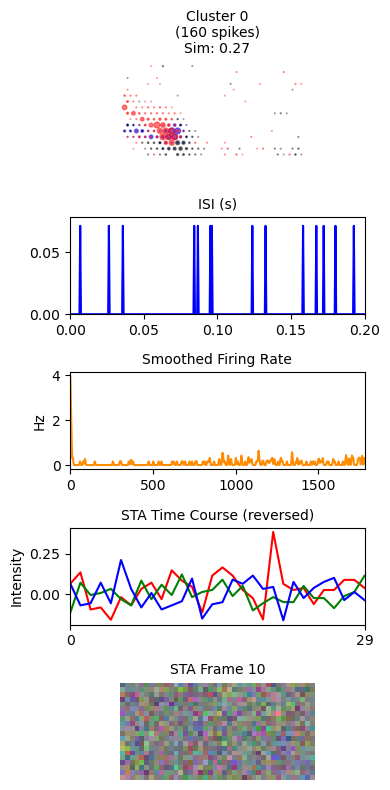

In [88]:
import analyze_clusters
import importlib
importlib.reload(analyze_clusters)


analyze_clusters.analyze_clusters(clusters,
                 spike_times=final_spike_times,
                 sampling_rate=20000,
                 dat_path='/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat',
                 h5_path='/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5',
                 triggers_mat_path='/Volumes/Lab/Users/alexth/axolotl/trigger_in_samples_201703151.mat',
                 cluster_ids=[0],
                 lut=None,
                 sta_depth=30,
                 sta_offset=0,
                 sta_chunk_size=1000,
                 sta_refresh=2,
                 ei_scale=3,
                 ei_cutoff=0.08, 
                 template_ei=ei_template)

### verify final cluster for overmerge

In [81]:
from verify_cluster import verify_cluster

spike_times_refined = final_spike_times[clusters[0]['inds']]

params = {
    'window': (-20, 60),
    'min_spikes': 100,
    'ei_sim_threshold': 0.95,
    'k_start': 8,
    'k_refine': 2
}

clusters_refined = verify_cluster(
    spike_times=spike_times_refined,
    dat_path='/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat',
    params=params
)

print(f"Returned {len(clusters_refined)} clean subclusters")
for i, cl in enumerate(clusters_refined):
    print(f"  Cluster {i}: {len(cl['inds'])} spikes")

Returned 1 clean subclusters
  Cluster 0: 160 spikes


/home/alexth/python_code/Axolotl_v2/plot_ei_python.py:60: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(positions[i], radii[i], color=color, alpha=alpha, edgecolor='none')
/home/alexth/python_code/Axolotl_v2/analyze_clusters.py:114: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax_isi.set_ylim(0, np.max(fractions) * 1.1)


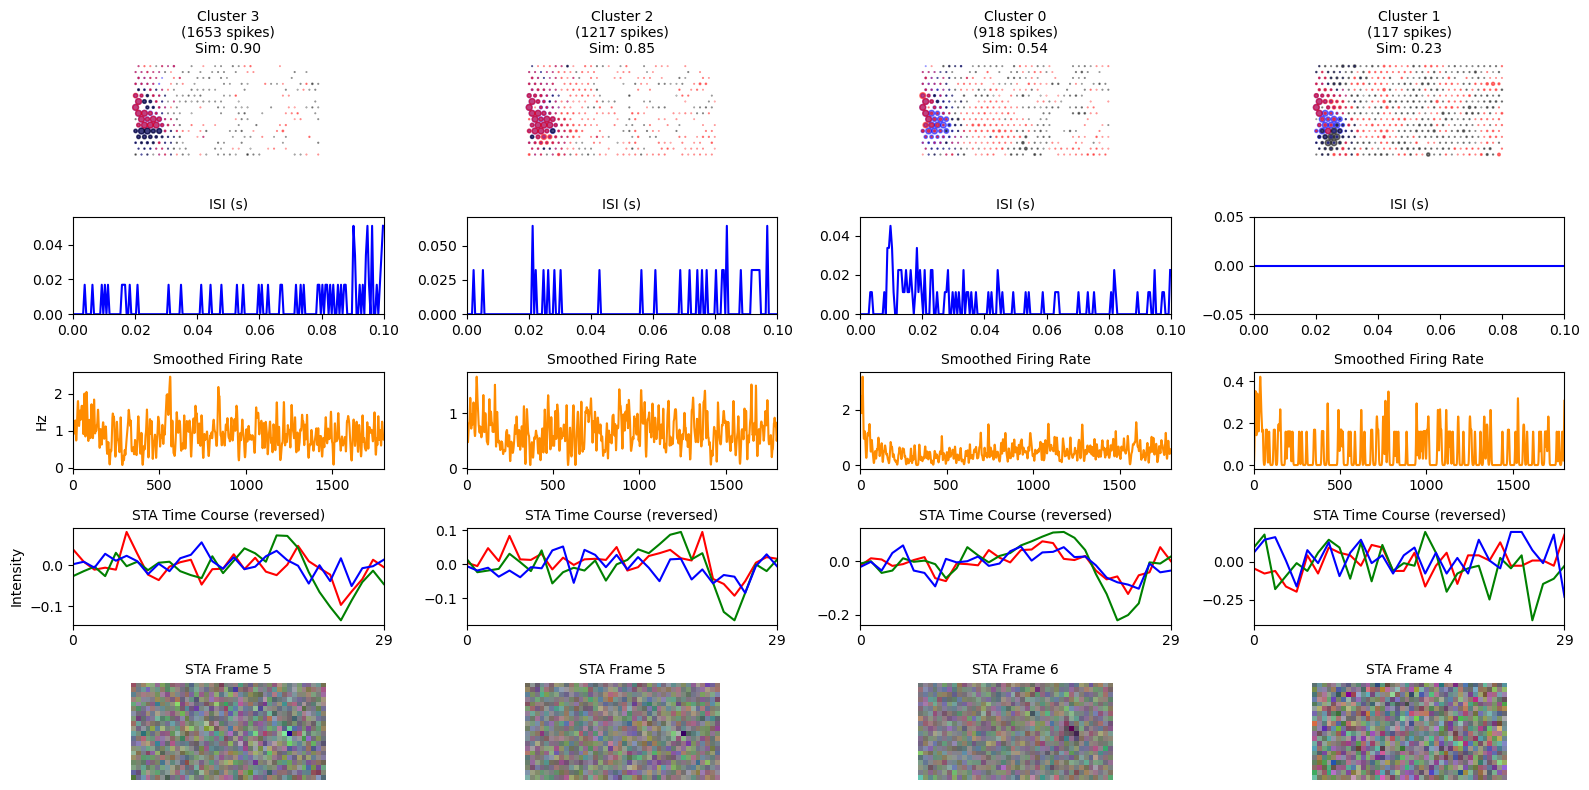

In [ ]:
import analyze_clusters
import importlib
importlib.reload(analyze_clusters)


analyze_clusters.analyze_clusters(clusters_refined,
                 spike_times=spike_times_refined,
                 sampling_rate=20000,
                 dat_path='/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat',
                 h5_path='/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5',
                 triggers_mat_path='/Volumes/Lab/Users/alexth/axolotl/trigger_in_samples_201703151.mat',
                 cluster_ids=None, #list(range(7, 13))
                 lut=None,
                 sta_depth=30,
                 sta_offset=0,
                 sta_chunk_size=1000,
                 sta_refresh=2,
                 ei_scale=3,
                 ei_cutoff=0.08, 
                 isi_max_ms=100,
                 template_ei=ei_template)

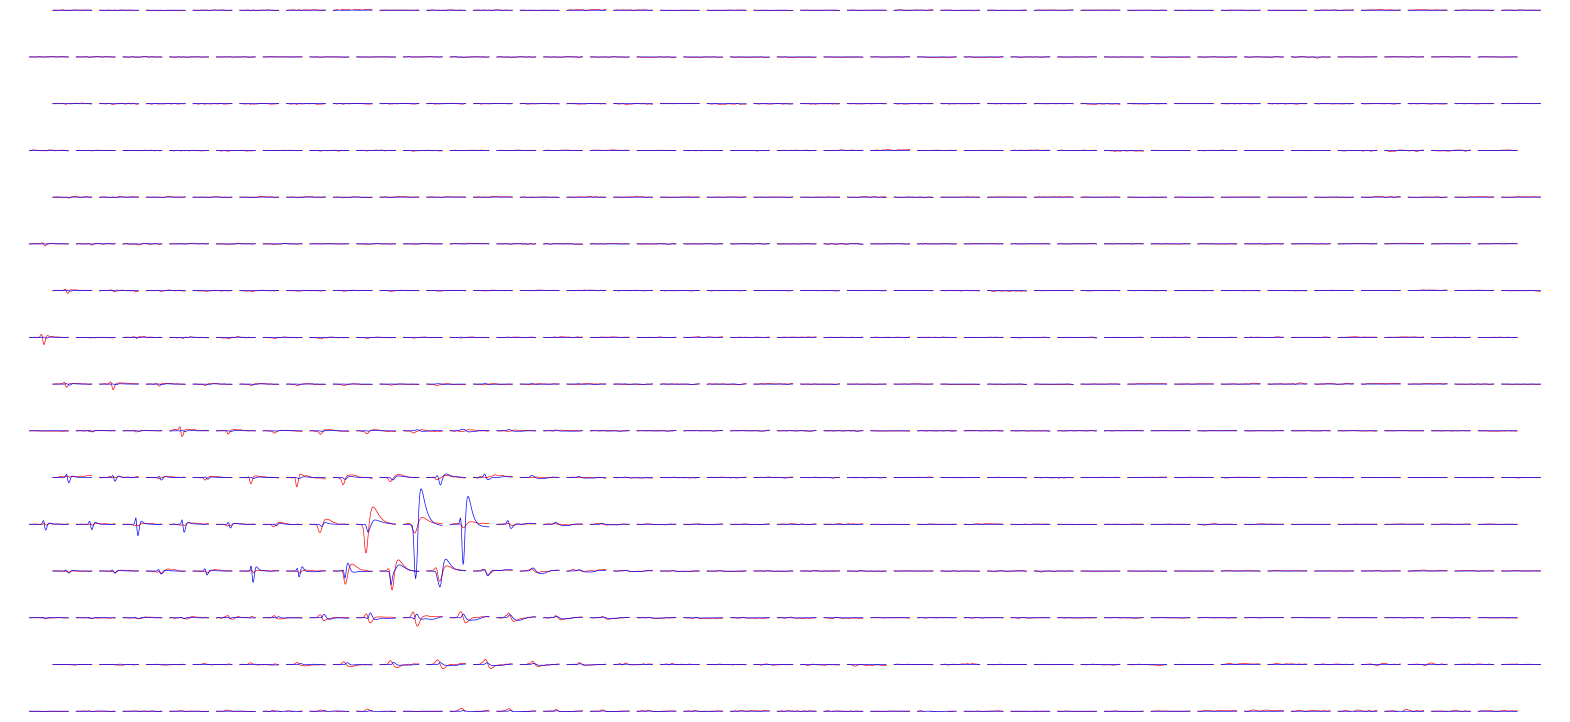

In [82]:
import plot_ei_waveforms
import importlib
importlib.reload(plot_ei_waveforms)
import matplotlib.pyplot as plt
import h5py
import numpy as np

h5_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'

with h5py.File(h5_path, 'r') as f:
    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]


#ei = clusters[1]['ei']

plt.figure(figsize=(20,20))

#plot_ei_waveforms.plot_ei_waveforms([clusters_refined[3]['ei'][:, 0:61], clusters_refined[2]['ei'][:, 0:61], ei_template], ei_positions,
#                  colors=[ 'red', 'blue', 'black'], scale=70, box_height=1.0, box_width=50)

#plot_ei_waveforms.plot_ei_waveforms([clusters_refined[3]['ei'][:, 0:61], clusters_refined[2]['ei'][:, 0:61],clusters_refined[0]['ei'][:, 0:61], ei_template], ei_positions,
#                  colors=[ 'red', 'blue', 'green','black'], scale=70, box_height=1.0, box_width=50)

plot_ei_waveforms.plot_ei_waveforms([clusters_refined[0]['ei'][:, 0:61], ei_template], ei_positions,
                  colors=[ 'red', 'blue', 'green','black'], scale=70, box_height=1.0, box_width=50)

#plot_ei_waveforms.plot_ei_waveforms(ei, ei_positions, scale=70.0, box_height=1.0, box_width=50.0, color='black')
plt.show()

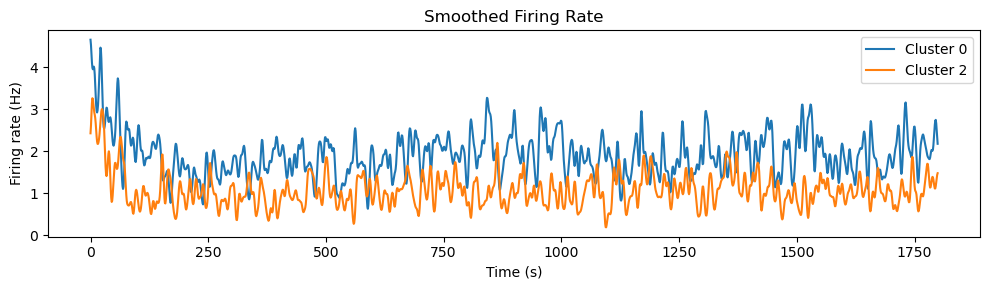

(array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
        1.799e+03]),
 array([[4.65693138, 4.53026051, 4.32618417, ..., 2.49104526, 2.30104193,
         2.17585945],
        [2.4260127 , 2.61058503, 2.89158743, ..., 1.35972184, 1.43553045,
         1.47472963]]))

In [35]:
from plot_smoothed_firing_rates import plot_smoothed_firing_rates

spike_times_1 = spike_times_refined[clusters_refined[0]['inds']] / sampling_rate
spike_times_2 = spike_times_refined[clusters_refined[2]['inds']] / sampling_rate

#plot_smoothed_firing_rates([spike_times_1, spike_times_2], labels=["Cluster 0", "Cluster 2"], sigma_ms=250, dt_ms=1, total_duration_s=100)
plot_smoothed_firing_rates([spike_times_1, spike_times_2], labels=["Cluster 0", "Cluster 2"], sigma_ms=2500, dt_ms=1000, total_duration_s=1800)

In [ ]:
from compute_and_plot_xcorr import compute_and_plot_xcorr

sampling_rate = 20000
# Get spike times (in seconds) from two clusters
spike_times_1 = spike_times_refined[clusters_refined[0]['inds']] / sampling_rate
spike_times_2 = spike_times_refined[clusters_refined[1]['inds']] / sampling_rate

compute_and_plot_xcorr(spike_times_1, spike_times_2, bin_size_ms=0.5, max_lag_ms=50)


In [71]:
from verify_cluster import verify_cluster

spike_times_refined1 = spike_times_refined[clusters_refined[0]['inds']]

params = {
    'window': (-20, 60),
    'min_spikes': 100,
    'ei_sim_threshold': 0.95,
    'k_start': 8,
    'k_refine': 2
}

clusters_refined1 = verify_cluster(
    spike_times=spike_times_refined1,
    dat_path='/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat',
    params=params
)

print(f"Returned {len(clusters_refined1)} clean subclusters")
for i, cl in enumerate(clusters_refined1):
    print(f"  Cluster {i}: {len(cl['inds'])} spikes")

Final EI similarity matrix:
 [[1.   0.38 0.24 0.49 0.48]
 [0.38 1.   0.27 0.7  0.68]
 [0.24 0.27 1.   0.51 0.54]
 [0.49 0.7  0.51 1.   0.8 ]
 [0.48 0.68 0.54 0.8  1.  ]]
[verify_cluster] Merged down to 5 final clusters.
Returned 5 clean subclusters
  Cluster 0: 111 spikes
  Cluster 1: 1096 spikes
  Cluster 2: 141 spikes
  Cluster 3: 1512 spikes
  Cluster 4: 1563 spikes


/home/alexth/python_code/Axolotl_v2/plot_ei_python.py:60: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(positions[i], radii[i], color=color, alpha=alpha, edgecolor='none')


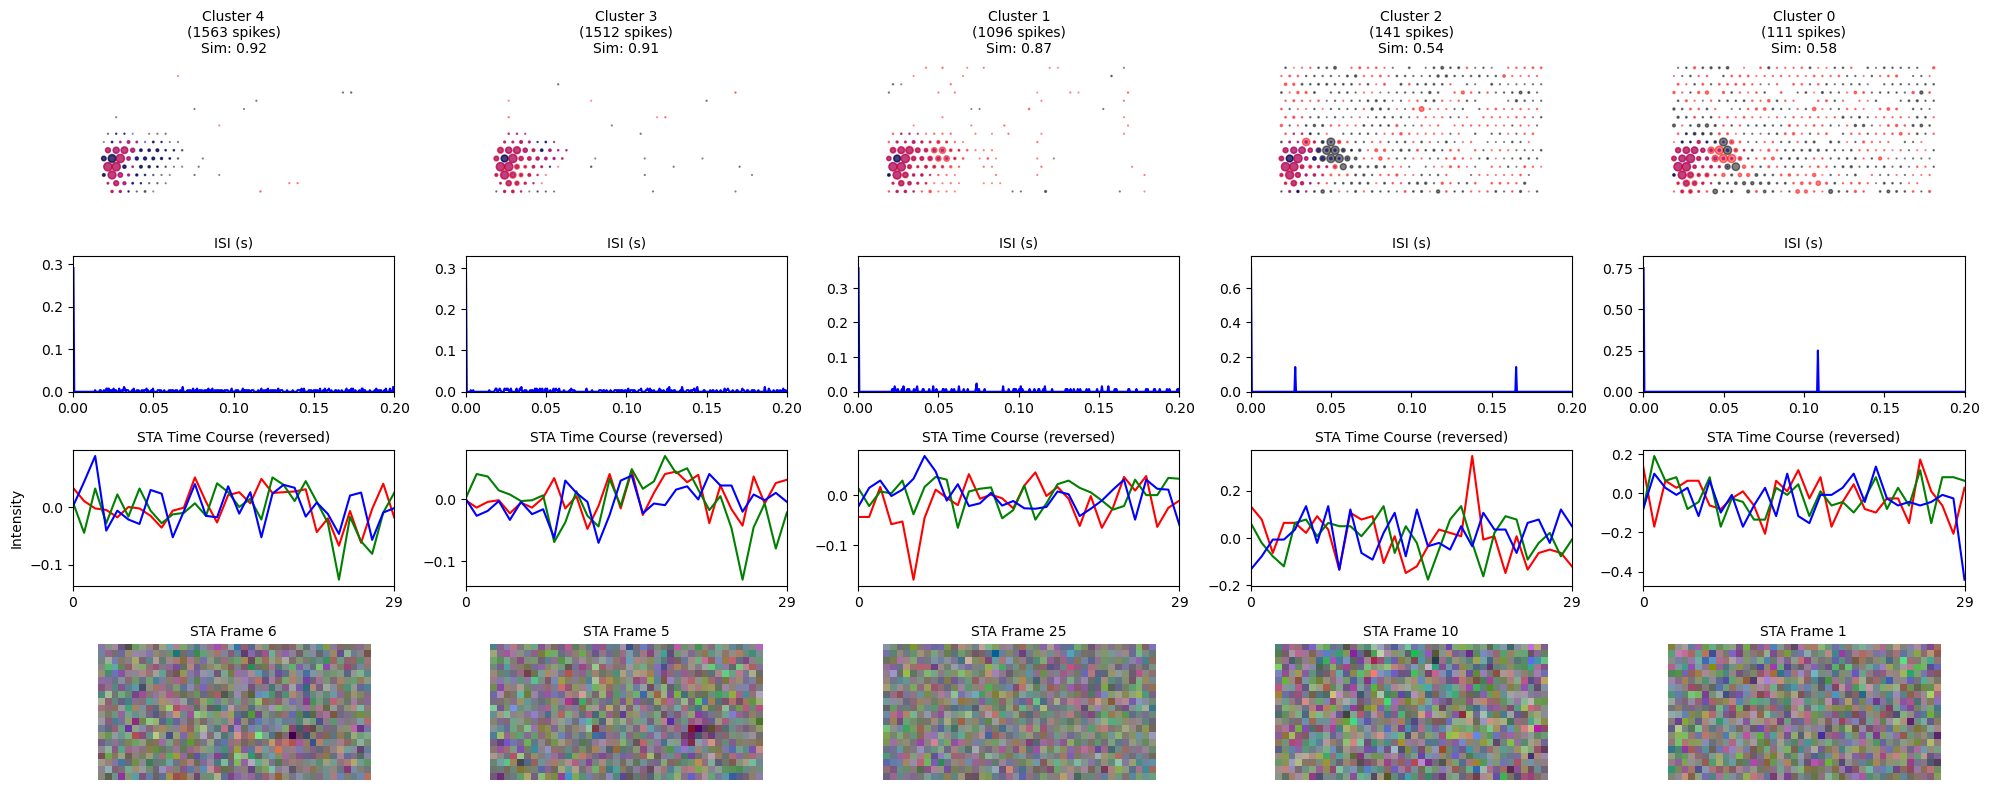

In [72]:
import analyze_clusters
import importlib
importlib.reload(analyze_clusters)


analyze_clusters.analyze_clusters(clusters_refined1,
                 spike_times=spike_times_refined1,
                 sampling_rate=20000,
                 dat_path='/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat',
                 h5_path='/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5',
                 triggers_mat_path='/Volumes/Lab/Users/alexth/axolotl/trigger_in_samples_201703151.mat',
                 cluster_ids=None, #list(range(7, 13))
                 lut=None,
                 sta_depth=30,
                 sta_offset=0,
                 sta_chunk_size=1000,
                 sta_refresh=2,
                 ei_scale=3,
                 ei_cutoff=0.08, 
                 template_ei=ei_template)

### analyze bursts

/home/alexth/python_code/Axolotl_v2/analyze_clusters.py:109: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax_isi.set_ylim(0, np.max(fractions) * 1.1)
/Volumes/Lab/Development/miniconda-peggyo/envs/autoencoder_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Volumes/Lab/Development/miniconda-peggyo/envs/autoencoder_env/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


ValueError: Axis limits cannot be NaN or Inf

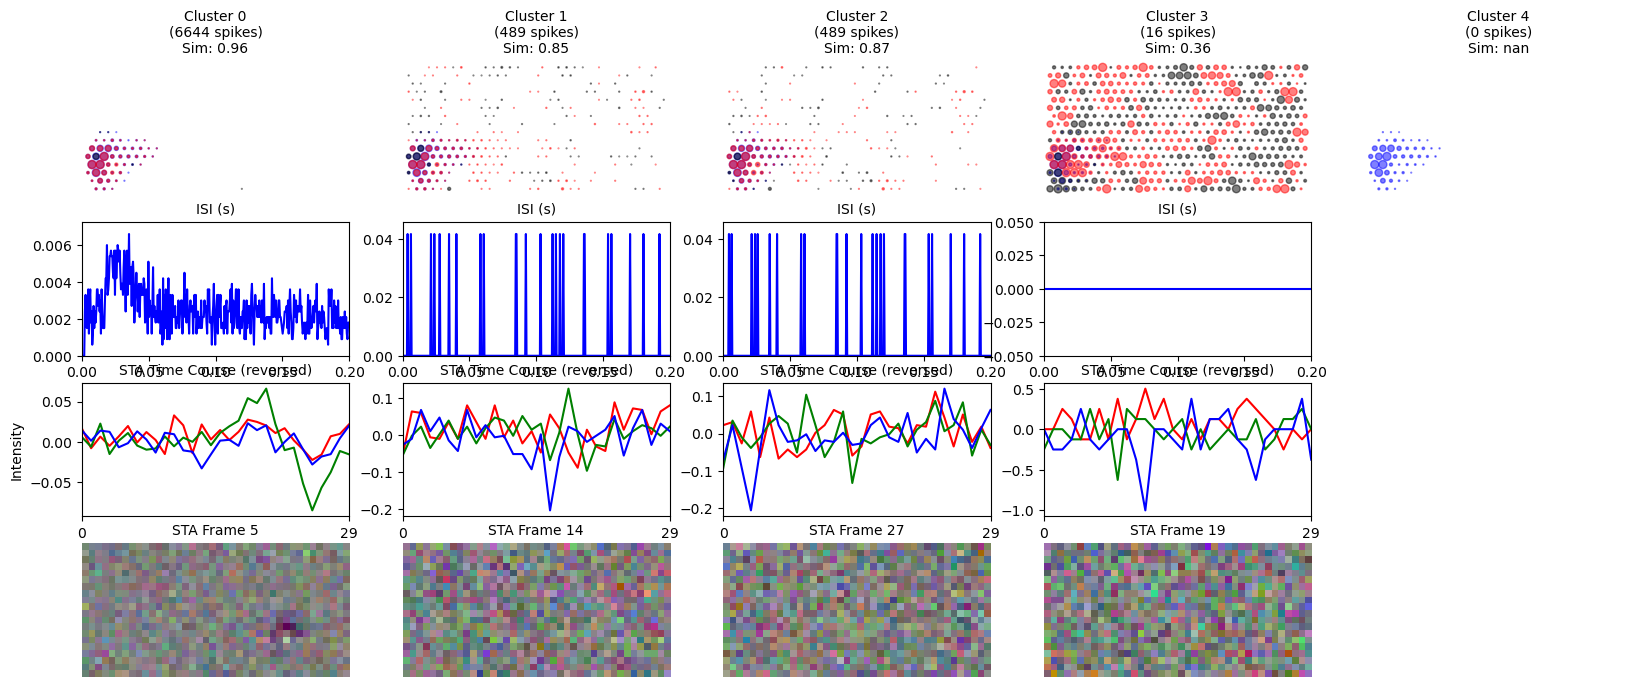

In [67]:
from split_spikes_by_burst import split_spikes_by_burst
import analyze_clusters
import importlib
importlib.reload(analyze_clusters)

#spike_times_refined = final_spike_times[clusters[10]['inds']]

clusters1 = split_spikes_by_burst(spike_times_refined, sampling_rate=20000)


analyze_clusters.analyze_clusters(clusters1,
                 spike_times=spike_times_refined,
                 sampling_rate=20000,
                 dat_path='/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat',
                 h5_path='/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5',
                 triggers_mat_path='/Volumes/Lab/Users/alexth/axolotl/trigger_in_samples_201703151.mat',
                 cluster_ids=None, #list(range(7, 13))
                 lut=None,
                 sta_depth=30,
                 sta_offset=0,
                 sta_chunk_size=1000,
                 sta_refresh=2,
                 ei_scale=3,
                 ei_cutoff=0.08, 
                 template_ei=ei_template)


In [85]:
# Merge [0,1,2,6] into one
inds_merge_1 = np.concatenate([clusters[i]['inds'] for i in [0]])

# Merge [3,4] into another
#inds_merge_2 = np.concatenate([clusters[i]['inds'] for i in [2,3]])

# Keep cluster[5] as-is
inds_keep = clusters[0]['inds']

# Final merged list of clusters (order doesn't matter here)
merged_clusters = [
 #   {'inds': inds_merge_1},
 #   {'inds': inds_merge_2},
    {'inds': inds_keep}
]


In [86]:
import analyze_clusters
import importlib
importlib.reload(analyze_clusters)


analyze_clusters.analyze_clusters(merged_clusters,
                 spike_times=final_spike_times,
                 sampling_rate=20000,
                 dat_path='/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat',
                 h5_path='/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5',
                 triggers_mat_path='/Volumes/Lab/Users/alexth/axolotl/trigger_in_samples_201703151.mat',
                 cluster_ids=[1],
                 lut=None,
                 sta_depth=30,
                 sta_offset=0,
                 sta_chunk_size=1000,
                 sta_refresh=2,
                 ei_scale=3,
                 ei_cutoff=0.08)

IndexError: list index out of range